# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python


tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
import numpy as np
import torch
import time
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from ddpg_agent import MultiAgent

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


# Train Agent

Below is the code that will actually loop through many rounds of training an agent to interact with the environment. The loop stops once the agent has solved the problem. A snapshot of the agent is saved for each episode in which there is an improvement in performance. 

In [5]:
# Set environment to train mode
env_info = env.reset(train_mode=True)[brain_name]

# Create agent
agent = MultiAgent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=42)

In [6]:
# TRAIN SETTINGS
max_t = 1000        # max number of timesteps per episode
solved_score = 30.0 # Score that must be met to be considered solved
solved_window = 100 # number of episodes used to calculate mean to check if solution satisified
print_every = 10    # How often to keep a persistent version of printout

# HISTORY - keep track of progress
scores_deque = deque(maxlen=solved_window) # used to average over window of last scores
scores = []         # track all history of episode scores
best_average_score = -np.inf

In [7]:
# TRAIN LOOP

epochs = 1000 # number of training epochs
print("{sep}\nTRAINING\n{sep}".format(sep="="*60))
print("Using Device: ", agent.device)
t0 =  time.time()
for i_episode in range(1, epochs+1):
    # RESET ENVIRONMENT, STATE AND SCORES
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    episode_scores = np.zeros(num_agents) # score for each agent within episode
    agent.reset()

    # COLLECT AN EPISODE OF EXPERIENCE FROM EACH AGENT
    for t in range(max_t):
        # A single step of interaction with the environment for each agent
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # Perform step of caching experience / training on experiences
        agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)

        # Sum up rewards separately for each agent
        episode_scores += np.array(rewards)

        # Prepare for next timestep of iteraction
        states = next_states  # new states become the current states

        # Check if any of the agents has finished. Finish to keep all
        # trajectories in this batch the same size.
        if np.any(dones):
            break

    # UPDATE SCORES
    episode_score = np.mean(episode_scores) # Summary of scores for this episode
    scores_deque.append(episode_score)
    average_score = np.mean(scores_deque)
    scores.append(episode_score)

    # FEEDBACK
    t1 = (time.time()-t0)/60. # time taken so far
    print('\rEpisode: {: 5d}\tTime (Mins): {:3.2f}\tAverage Score: {: 3.2f}\tCurrent Score: {: 3.2f}'.format(i_episode, t1, average_score, episode_score), end="")
    if i_episode % print_every == 0:
        print('\rEpisode: {: 5d}\tTime (Mins): {:3.2f}\tAverage Score: {: 3.2f}\tCurrent Score: {: 3.2f}'.format(i_episode, t1, average_score, episode_score))

    # SAVE SNAPSHOT - if it is better than previous models
    if (i_episode >= solved_window) and (average_score > best_average_score):
        best_average_score = average_score
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

    # CHECK IF SOLVED
    if average_score >= solved_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-solved_window, average_score))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        break


TRAINING
Using Device:  cuda:0
Episode:    10	Time (Mins): 4.15	Average Score:  0.13	Current Score:  0.04
Episode:    20	Time (Mins): 9.16	Average Score:  0.33	Current Score:  1.12
Episode:    30	Time (Mins): 15.58	Average Score:  0.63	Current Score:  1.41
Episode:    40	Time (Mins): 23.59	Average Score:  0.91	Current Score:  2.46
Episode:    50	Time (Mins): 33.22	Average Score:  1.38	Current Score:  3.99
Episode:    60	Time (Mins): 43.65	Average Score:  1.96	Current Score:  5.32
Episode:    70	Time (Mins): 54.09	Average Score:  2.55	Current Score:  7.64
Episode:    80	Time (Mins): 64.76	Average Score:  3.21	Current Score:  8.47
Episode:    90	Time (Mins): 75.30	Average Score:  3.80	Current Score:  8.95
Episode:   100	Time (Mins): 85.81	Average Score:  4.48	Current Score:  10.64
Episode:   110	Time (Mins): 96.28	Average Score:  5.81	Current Score:  14.41
Episode:   120	Time (Mins): 106.76	Average Score:  7.22	Current Score:  15.29
Episode:   130	Time (Mins): 117.39	Average Score:  8.62

In [8]:
# CLOSE ENVIRONMENT
env.close()

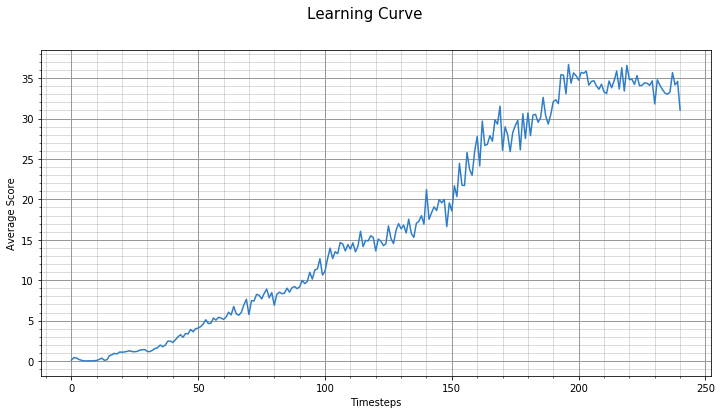

In [9]:
# LEARNING CURVE
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Learning Curve", fontsize=15)
ax.plot(scores, color="#307EC7", label="line")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Average Score")
# GRID
ax.grid(True)
ax.grid(b=True, which='major', color='#999999', linestyle='-', linewidth=1)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.7, linewidth=0.5)
fig.savefig("learning_curves.jpg")